In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xscale
import xgcm
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.21:42893 Dashboard: http://10.148.1.21:8787/status,Cluster Workers: 22 Cores: 88 Memory: 1100.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,ds_D,ds_B,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center
Z Axis (not periodic):
  * center   depth (52) --> left
  * left     depth_left (52) --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 ...
  * depth       (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 ...
  * time        (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 ...
  * lon         (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ..

_______________
# 2. within a subdomain
## 2.1 define perturbation (e.g., u', v')

In [9]:
w_mean = ds.W.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon'])
b_mean = ds.Buoy.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon'])
u_mean = ds.U.isel(lon_g=slice(80,100),lat=slice(90,110)).mean(['lat','lon_g'])
v_mean = ds.V.isel(lon=slice(80,100),lat_g=slice(90,110)).mean(['lat_g','lon'])

In [11]:
w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean
u_prime = ds.U - u_mean
v_prime = ds.V - v_mean

In [12]:
u_prime_ij = gridx.interp(u_prime,'X')
u_prime_ij

<xarray.DataArray 'mul-d5e67ade9c084d449403132e7ad3d0e1' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [13]:
v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

<xarray.DataArray 'mul-92100683a4fd8a056755d3113ed3dd04' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [14]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-7add37a4a6b0bac4d68c4629d8896ad4' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [15]:
dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')
print(dV_dz_ij)

<xarray.DataArray 'mul-c8759d9ea7a020a541459c9e6db680e3' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


## 2.2 VSP

In [16]:
vsp = -1*((w_prime.isel(lon=slice(80,100),lat=slice(90,110)) * u_prime_ij.isel(lon=slice(80,100),lat=slice(90,110))).mean(['lat','lon']) * dU_dz_ij.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon']) + (w_prime.isel(lon=slice(80,100),lat=slice(90,110)) * v_prime_ij.isel(lon=slice(80,100),lat=slice(90,110))).mean(['lat','lon']) * dV_dz_ij.isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon']))
vsp

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float64, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

In [17]:
vsp.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[          nan,  6.643062e-09,  7.752045e-09, ..., -4.915109e-10,
        -5.746316e-10, -4.568061e-10],
       [          nan,  6.019086e-09,  7.656449e-09, ..., -3.266228e-09,
        -3.629195e-09, -2.014204e-09],
       [          nan,  5.599932e-09,  7.141685e-09, ..., -4.817365e-09,
        -3.680153e-09, -1.778389e-09],
       ...,
       [          nan,  1.783752e-09,  3.846320e-09, ..., -1.340823e-09,
        -1.008371e-09, -7.343099e-10],
       [          nan,  4.769219e-09,  5.944847e-09, ...,  4.186362e-09,
         4.174460e-09,  1.631230e-09],
       [          nan,  7.542264e-09,  9.875501e-09, ..., -5.228347e-10,
        -8.634969e-10,  2.471092e-10]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

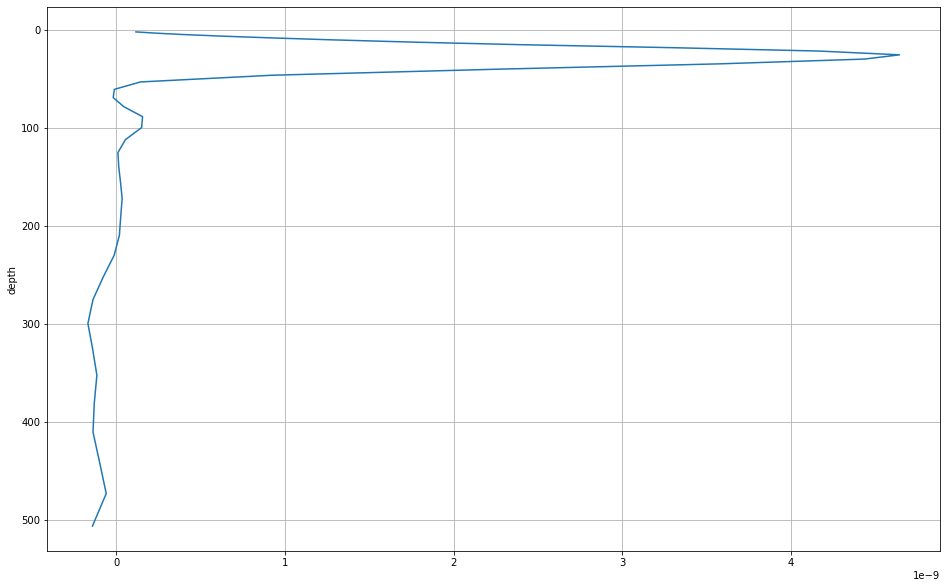

In [18]:
fig, ax = plt.subplots(figsize=(16,10))
vsp.isel(depth=slice(0,40)).mean('time').plot(y='depth', yincrease=False)
ax.grid()

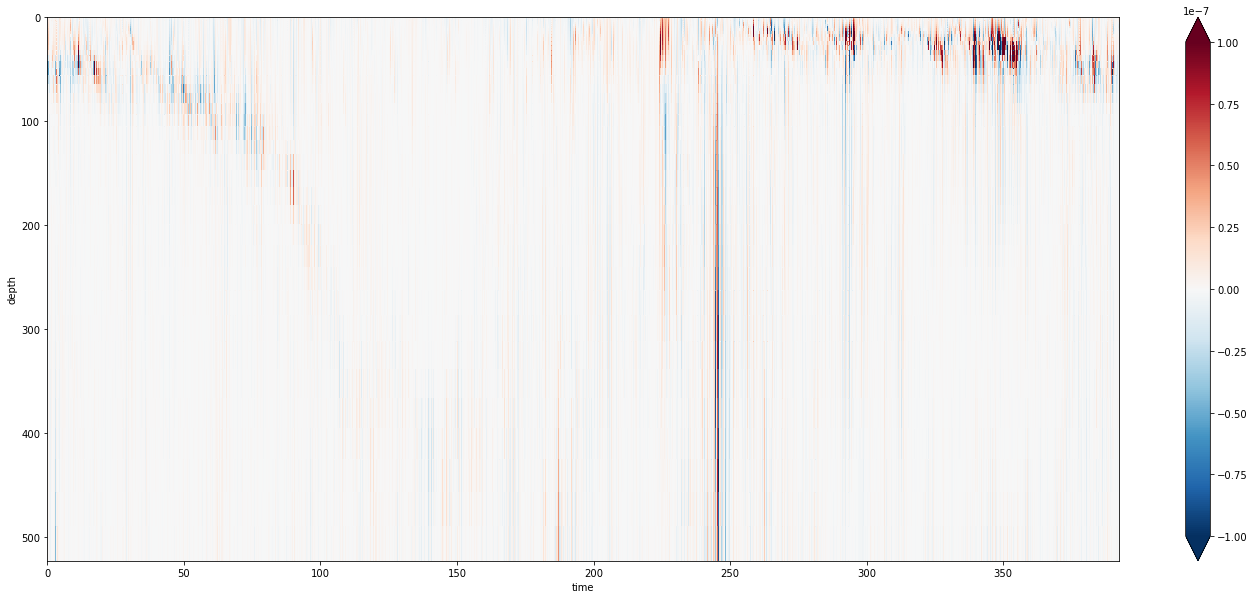

In [19]:
fig = plt.figure(figsize=(24,10))
vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)

## 2.3 w'b'

In [20]:
wb_prime = (w_prime*b_prime).isel(lon=slice(80,100),lat=slice(90,110)).mean(['lat','lon'])
wb_prime

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float32, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

In [21]:
wb_prime.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[ 9.104631e-12, -1.899678e-10, -4.192681e-10, ...,  2.785053e-07,
         2.464536e-07,  2.183113e-07],
       [-4.385067e-11, -3.040994e-10, -6.047045e-10, ...,  1.085857e-07,
         7.949939e-08,  5.438296e-08],
       [-1.231595e-10, -2.458412e-10, -3.901912e-10, ..., -3.599114e-08,
        -8.349607e-08, -1.195736e-07],
       ...,
       [ 1.294556e-10, -1.598580e-09, -3.193619e-09, ...,  9.649757e-09,
         7.874039e-09,  2.366424e-08],
       [-5.421089e-11,  4.716851e-10,  2.065393e-09, ...,  6.812529e-08,
         5.658874e-08,  3.094108e-08],
       [ 3.666771e-11,  1.945442e-09,  4.195892e-09, ...,  1.574261e-07,
         1.617225e-07,  7.900421e-08]], dtype=float32)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

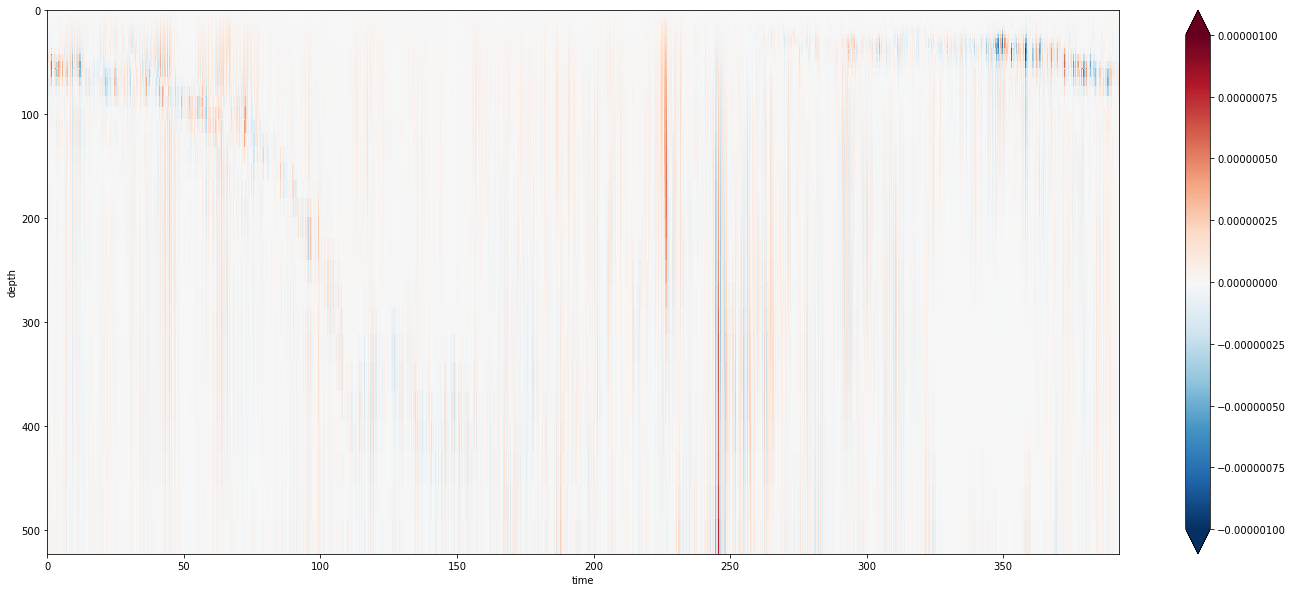

In [22]:
fig = plt.figure(figsize=(24,10))
wb_prime.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-6,vmax=1e-6,cmap='RdBu_r', yincrease=False)

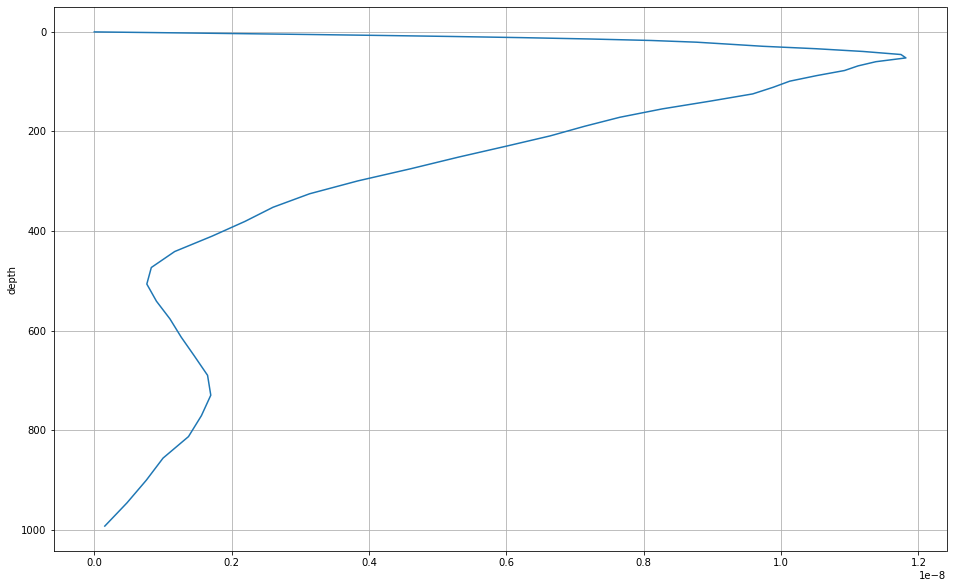

In [23]:
fig, ax = plt.subplots(figsize=(16,10))

wb_prime.mean('time').plot(y='depth', yincrease=False)
ax.grid()

## 2.4 VSP vs. w'b'

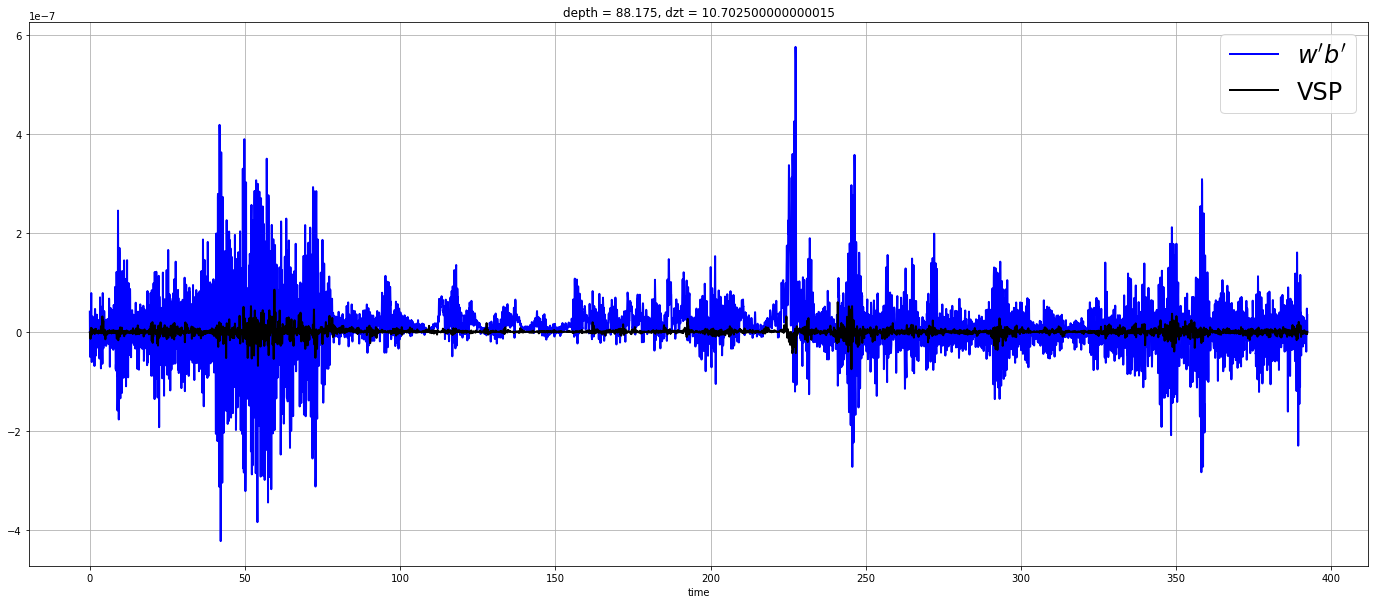

In [24]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime.isel(depth=20).plot(ax=ax, color='blue', label=labels[1], linewidth=2)
vsp.isel(depth=20).plot(ax=ax, color='black', label=labels[0], linewidth=2)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

(-4e-09, 1.2e-08)

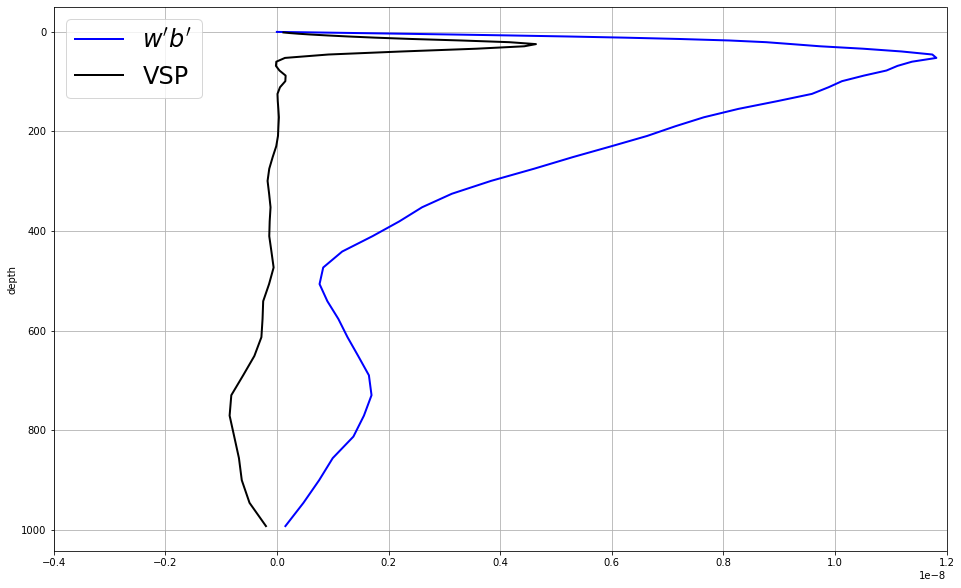

In [25]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(16,10))
wb_prime.mean('time').plot(ax=ax, color='blue', label=labels[1], linewidth=2, y='depth', yincrease=False)
vsp.mean('time').plot(ax=ax, color='black', label=labels[0], linewidth=2, y='depth', yincrease=False)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_xlim([-.4e-8,1.2e-8])

_______________

# 3. Filtered results

## 3.1 an example of low-pass filter 

Window [order->{'time': 80}, cutoff->{'time': 24}, dx->{'time': 1}, window->{'time': 'hanning'}]


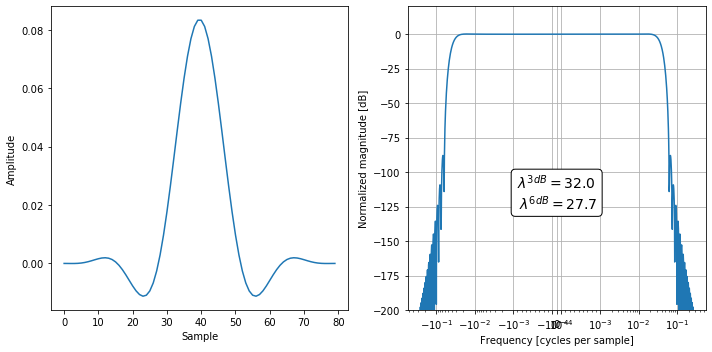

In [26]:
wt = ds.U.window
wt.set()

cutoff_time = 24 # A 24-hour cutoff
dx_time = 1 # Define the sampling period (one hour)
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

wt.plot()
print(wt)

In [27]:
U_filter = wt.convolve(trim=True)
U_filter = np.real(U_filter).rename('U_filter')
U_filter

<xarray.DataArray 'U_filter' (time: 9415, depth: 52, lat: 201, lon_g: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dxC      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    rAw      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt      (depth) float64 dask.array<shape=(52,), chunksize=(52,)>

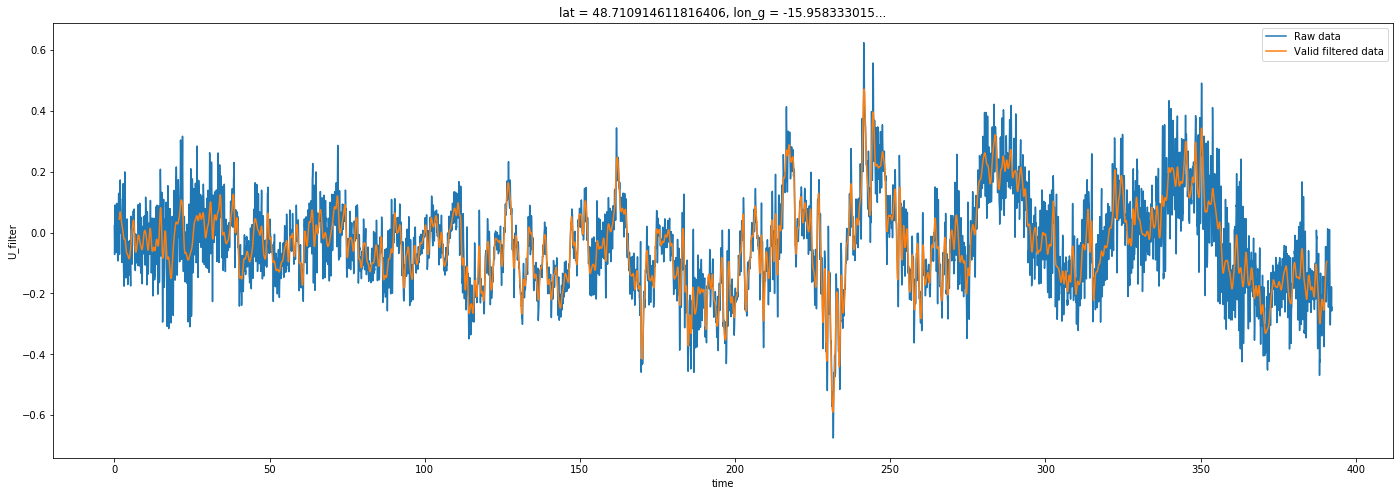

In [28]:
plt.figure(figsize=(24,8))

ds.U.isel(lat=100, lon_g=100,depth=2).plot(label="Raw data")
U_filter.isel(lat=100, lon_g=100,depth=2).plot(label="Valid filtered data")
plt.legend()
plt.show()

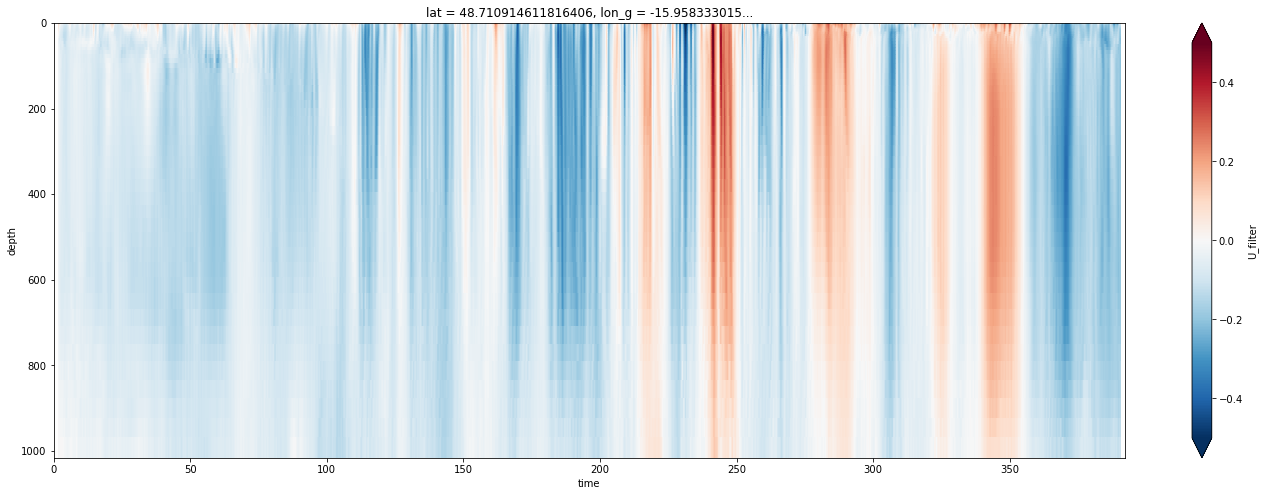

In [56]:
plt.figure(figsize=(24,8))
U_filter.isel(lat=100, lon_g=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap='RdBu_r', yincrease=False)

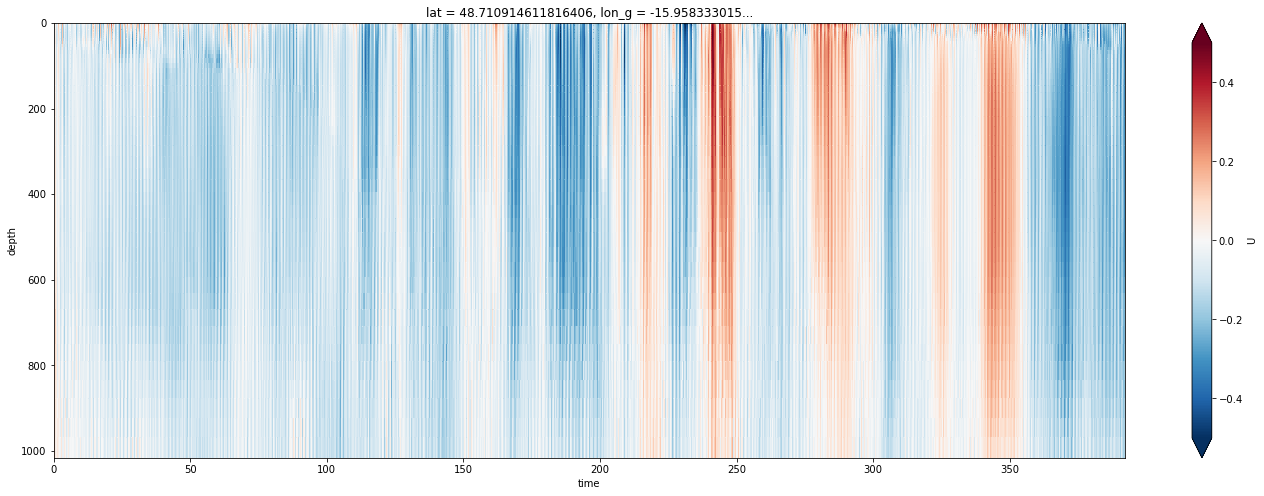

In [57]:
plt.figure(figsize=(24,8))
ds.U.isel(lat=100, lon_g=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap='RdBu_r', yincrease=False)

## 3.2 low-pass filtered data

In [29]:
wt = ds.U.window
wt.set()
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

U_filter = wt.convolve(trim=True)
U_filter = np.real(U_filter).rename('U_filter')

In [30]:
wt = ds.V.window
wt.set()
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

V_filter = wt.convolve(trim=True)
V_filter = np.real(V_filter).rename('V_filter')

In [31]:
wt = ds.W.window
wt.set()
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

W_filter = wt.convolve(trim=True)
W_filter = np.real(W_filter).rename('W_filter')

In [32]:
wt = ds.Buoy.window
wt.set()
wt.set(n=80, dim='time', cutoff=cutoff_time, dx=dx_time, window='hanning')

B_filter = wt.convolve(trim=True)
B_filter = np.real(B_filter).rename('B_filter')

## 3.3 Define perturbation

In [33]:
w_mean = W_filter.mean(['lat','lon'])
b_mean = B_filter.mean(['lat','lon'])
u_mean = U_filter.mean(['lat','lon_g'])
v_mean = V_filter.mean(['lat_g','lon'])

In [34]:
w_prime = W_filter - w_mean
b_prime = B_filter - b_mean
u_prime = U_filter - u_mean
v_prime = V_filter - v_mean

In [35]:
u_prime_ij = gridx.interp(u_prime,'X')
u_prime_ij

<xarray.DataArray 'mul-62dd7bb2a3bf6b45664a4404262c428c' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [36]:
v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

<xarray.DataArray 'mul-93408ea7f7108ef68098d78a74ed36ac' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [37]:
dU_dz_left = -1*gridx.diff(U_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-b71fda4d385d91e7bdb2f5189391d6d7' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


In [38]:
dV_dz_left = -1*gridx.diff(V_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')
print(dV_dz_ij)

<xarray.DataArray 'mul-693488ad50ce706b14ce17f3bb3fd540' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


## 3.4 VSP

In [36]:
vsp = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime* v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float64, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 dask.array<shape=(52,), chunksize=(52,)>

In [37]:
vsp.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

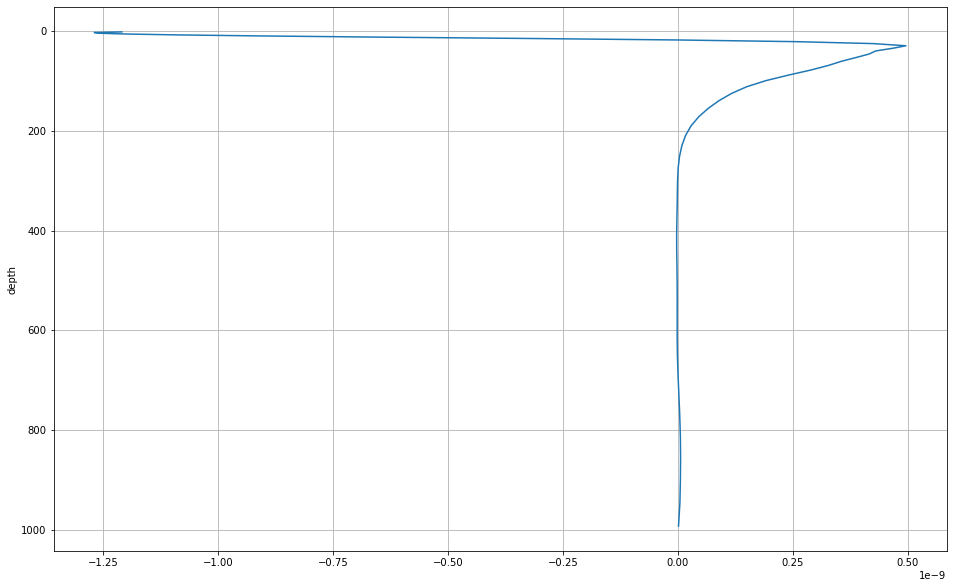

In [39]:
fig, ax = plt.subplots(figsize=(16,10))
vsp.mean('time').plot(y='depth', yincrease=False)
ax.grid()

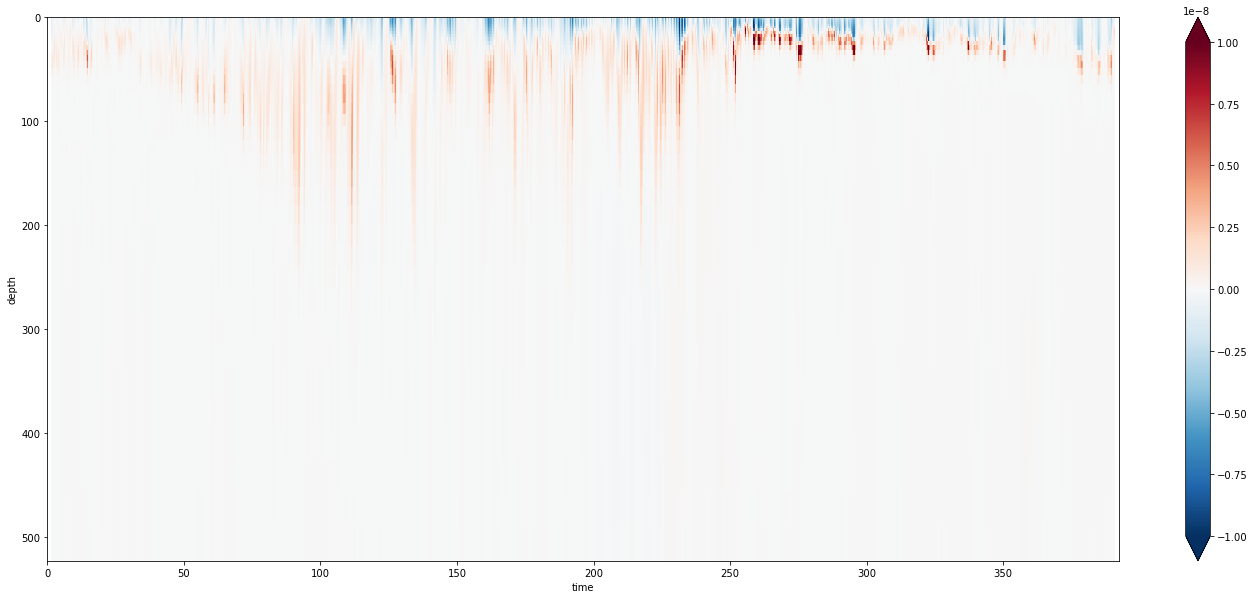

In [41]:
fig = plt.figure(figsize=(24,10))
vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)

## 3.5 w'b'

In [42]:
wb_prime = w_prime*b_prime
wb_prime_mean = wb_prime.mean(['lat','lon'])
wb_prime_mean

<xarray.DataArray (time: 9415, depth: 52)>
dask.array<shape=(9415, 52), dtype=float32, chunksize=(9415, 1)>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 dask.array<shape=(52,), chunksize=(52,)>

In [43]:
wb_prime_mean.load()

<xarray.DataArray (time: 9415, depth: 52)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 2.207 2.51 ...

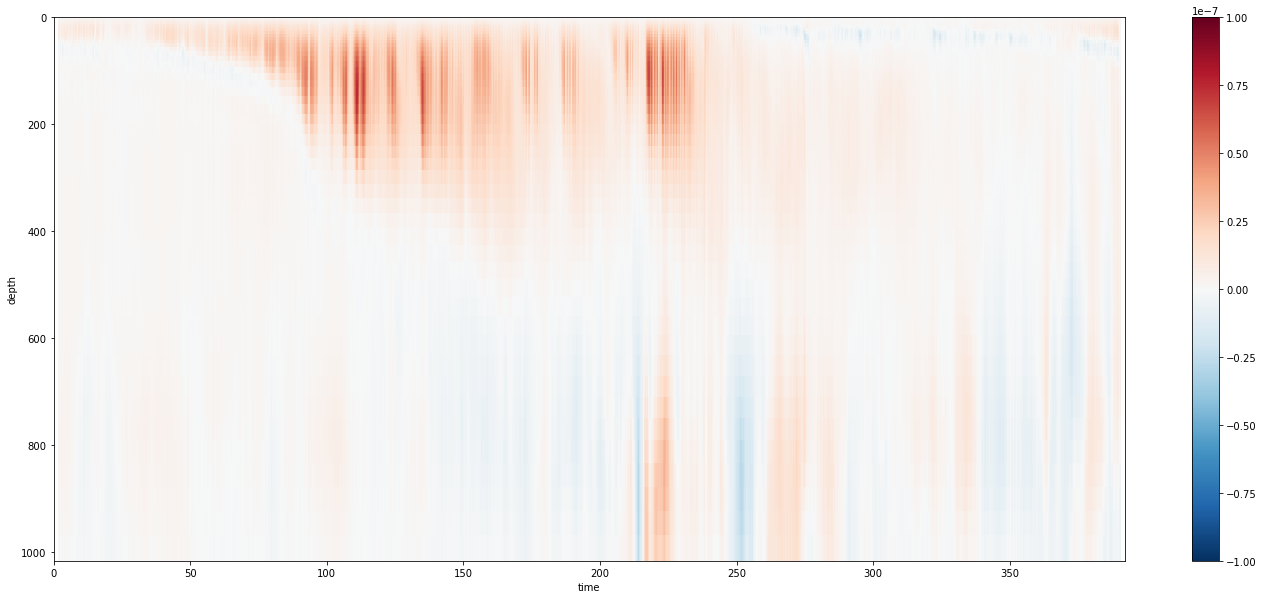

In [44]:
fig = plt.figure(figsize=(24,10))
wb_prime_mean.plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)

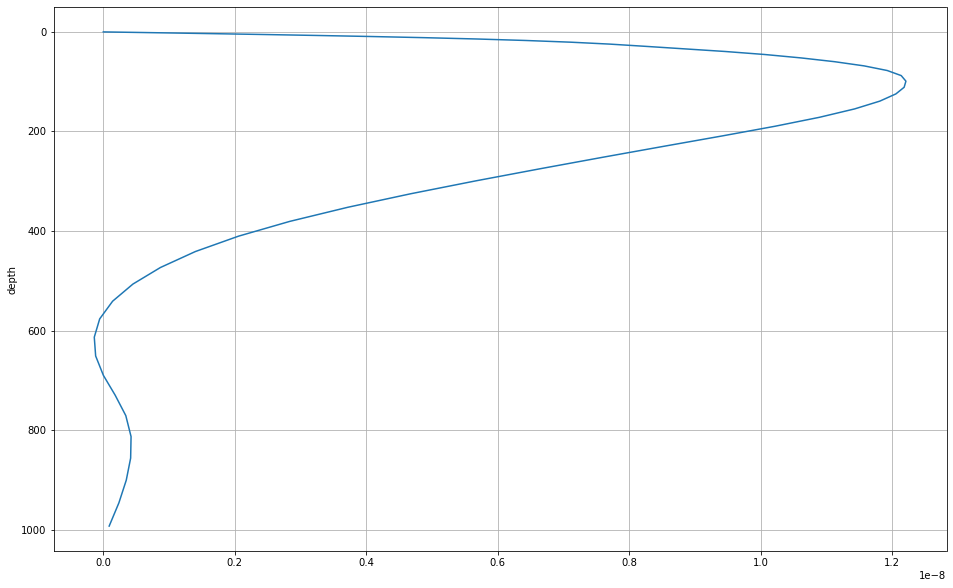

In [46]:
fig, ax = plt.subplots(figsize=(16,10))

wb_prime_mean.mean('time').plot(y='depth', yincrease=False)
ax.grid()

## 3.6 VSP vs. w'b'

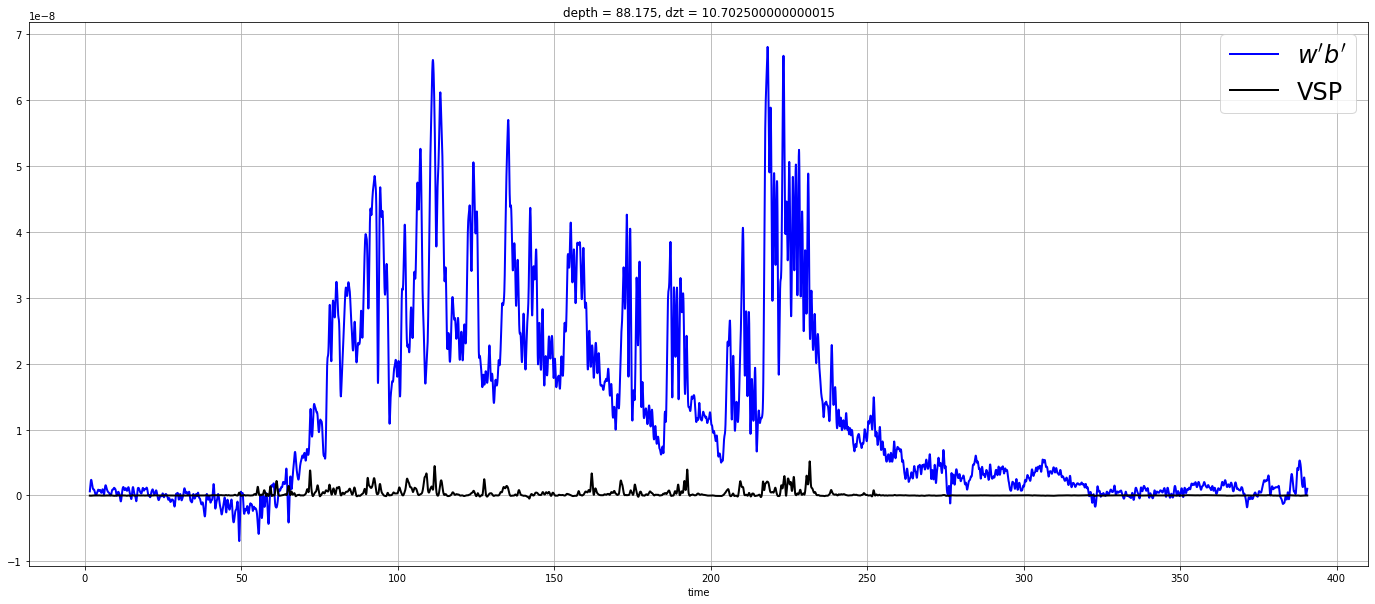

In [50]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime_mean.isel(depth=20).plot(ax=ax, color='blue', label=labels[1], linewidth=2)
vsp.isel(depth=20).plot(ax=ax, color='black', label=labels[0], linewidth=2)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

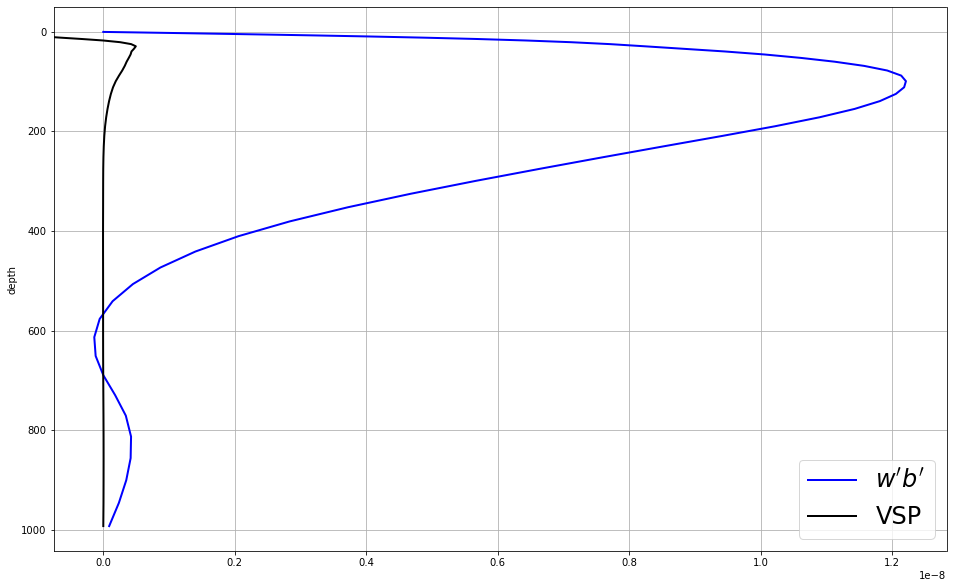

In [51]:
labels = ['VSP', '$w^\prime b^\prime$']

fig, ax = plt.subplots(figsize=(16,10))
wb_prime_mean.mean('time').plot(ax=ax, color='blue', label=labels[1], linewidth=2, y='depth', yincrease=False)
vsp.mean('time').plot(ax=ax, color='black', label=labels[0], linewidth=2, y='depth', yincrease=False)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

In [40]:
cluster.scheduler.close()

<Future finished result=None>

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 842, in _reconnect
    yield self._ensure_connected()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/client.py", line 873, in _ensure_connected
    assert len(msg) == 1
AssertionError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.